# Neural Net Classifier

In [74]:
# Hyperparameters:
batch_size = 128
learning_rate = 0.0005
epochs = 30
hidden_layer_1 = 128
hidden_layer_2 = 64

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision.models as models
import kagglehub
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

In [76]:
train_set = torch.load("./Datasets/train_set.pt", weights_only=False)
val_set = torch.load("./Datasets/val_set.pt", weights_only=False)

In [77]:
def preprocess_tensor(tensor):
    return torch.nan_to_num(tensor, nan=0.0)  # Replace NaN with 0.0

# Preprocess train and validation datasets
train_set = [(preprocess_tensor(x), y) for x, y in train_set]
val_set = [(preprocess_tensor(x), y) for x, y in val_set]

In [78]:
# Convert datasets into tensor datasets
train_data = TensorDataset(
    torch.stack([x for x, y in train_set]),
    torch.tensor([y.item() for x, y in train_set]).float()
)
val_data = TensorDataset(
    torch.stack([x for x, y in val_set]),
    torch.tensor([y.item() for x, y in val_set]).float()
)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [79]:
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_1)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.fc3 = nn.Linear(hidden_layer_2, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = train_set[0][0].shape[0]
model = RegressionNN(input_size)

In [80]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [81]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses


In [82]:
# Train the model and capture the losses
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Epoch [1/30], Train Loss: 14228.4885, Val Loss: 12434.3104
Epoch [2/30], Train Loss: 16056.0836, Val Loss: 12346.9009
Epoch [3/30], Train Loss: 14157.7155, Val Loss: 12216.7848
Epoch [4/30], Train Loss: 13601.1039, Val Loss: 12013.4959
Epoch [5/30], Train Loss: 14122.5624, Val Loss: 11716.3888
Epoch [6/30], Train Loss: 13041.1584, Val Loss: 11258.9243
Epoch [7/30], Train Loss: 14823.1127, Val Loss: 10624.9344
Epoch [8/30], Train Loss: 12779.1479, Val Loss: 9783.2703
Epoch [9/30], Train Loss: 10349.1023, Val Loss: 8751.0465
Epoch [10/30], Train Loss: 9003.6483, Val Loss: 7524.4823
Epoch [11/30], Train Loss: 7947.6939, Val Loss: 6194.6414
Epoch [12/30], Train Loss: 5495.9463, Val Loss: 4778.4124
Epoch [13/30], Train Loss: 4064.5144, Val Loss: 3513.0180
Epoch [14/30], Train Loss: 2656.3465, Val Loss: 2536.6171
Epoch [15/30], Train Loss: 1742.3549, Val Loss: 2016.7132
Epoch [16/30], Train Loss: 1548.2358, Val Loss: 1777.6950
Epoch [17/30], Train Loss: 1489.2781, Val Loss: 1719.4572
Epoch [

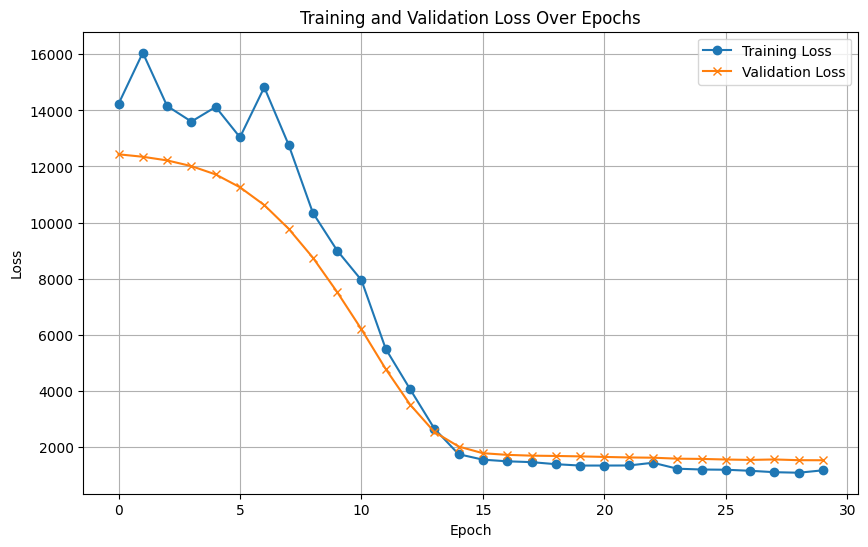

In [83]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    
    mse = mean_squared_error(actuals, predictions)
    rmse = root_mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # Print results
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root MSE: {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

# Evaluate on validation data
evaluate_model(model, val_loader)

Mean Squared Error: 1504.7273
Root MSE: 38.7908
Mean Absolute Error (MAE): 28.2512
R² Score: 0.8186


In [91]:
'''
# Save the model's state dictionary and metadata
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'val_loss': val_losses
}, './Models/nn_checkpoint.pth')

# Save just the state dictionary for evaluation
torch.save(model.state_dict(), './Models/nn.pth')
'''

"\n# Save the model's state dictionary and metadata\ntorch.save({\n    'epoch': epochs,\n    'model_state_dict': model.state_dict(),\n    'optimizer_state_dict': optimizer.state_dict(),\n    'train_loss': train_losses,\n    'val_loss': val_losses\n}, './Models/nn_checkpoint.pth')\n\n# Save just the state dictionary for evaluation\ntorch.save(model.state_dict(), './Models/nn.pth')\n"